# Interpreting Nodes and Edges by Saliency Maps in GAT

This demo shows how to use integrated gradients in graph attention networks to obtain accurate importance estimations for both the nodes and edges. The notebook consists of three parts:

setting up the node classification problem for Cora citation network
training and evaluating a GAT model for node classification
calculating node and edge importances for model's predictions of query ("target") nodes.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import os
import time
import sys
import stellargraph as sg
from copy import deepcopy


from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT, GraphAttention

from tensorflow.keras import layers, optimizers, losses, metrics, models, Model
from sklearn import preprocessing, feature_extraction, model_selection
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

### Loading the CORA network

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
dataset.download()

Load the graph from edgelist

In [3]:
edgelist = pd.read_csv(
    os.path.join(dataset.data_directory, "cora.cites"),
    header=None,
    names=["source", "target"],
    sep="\t",
)
edgelist["label"] = "cites"

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names = feature_names + ["subject"]
node_data = pd.read_csv(
    os.path.join(dataset.data_directory, "cora.content"),
    header=None,
    names=column_names,
    sep="\t",
)

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [7]:
train_data, test_data = model_selection.train_test_split(
    node_data, train_size=140, test_size=None, stratify=node_data["subject"]
)
val_data, test_data = model_selection.train_test_split(
    test_data, train_size=500, test_size=None, stratify=test_data["subject"]
)

In [8]:
from collections import Counter

Counter(train_data["subject"])

Counter({'Neural_Networks': 42,
         'Theory': 18,
         'Probabilistic_Methods': 22,
         'Reinforcement_Learning': 11,
         'Genetic_Algorithms': 22,
         'Case_Based': 16,
         'Rule_Learning': 9})

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [9]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict("records"))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict("records"))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict("records"))

node_ids = node_data.index
all_targets = target_encoding.transform(node_data[["subject"]].to_dict("records"))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [10]:
node_features = node_data[feature_names]

### Creating the GAT model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [11]:
G = sg.StellarGraph(Gnx, node_features=node_features)
print(G.info())

NetworkXStellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



To feed data from the graph to the Keras model we need a generator. Since GAT is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and graph adjacency matrix to the model.

In [12]:
generator = FullBatchNodeGenerator(G, method="gat", sparse=False)

For training we map only the training nodes returned from our splitter and the target values.

In [13]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GAT layers with 8-dimensional hidden node features at each layer.
 * `attn_heads` is the number of attention heads in all but the last GAT layer in the model
 * `activations` is a list of activations applied to each layer's output
 * Arguments such as `bias`, `in_dropout`, `attn_dropout` are internal parameters of the model, execute `?GAT` for details. 

To follow the GAT model architecture used for Cora dataset in the original paper [Graph Attention Networks. P. Velickovic et al. ICLR 2018 https://arxiv.org/abs/1803.07294], let's build a 2-layer GAT model, with the 2nd layer being the classifier that predicts paper subject: it thus should have the output size of `train_targets.shape[1]` (7 subjects) and a softmax activation.

In [14]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    attn_heads=8,
    generator=generator,
    bias=True,
    in_dropout=0,
    attn_dropout=0,
    activations=["elu", "softmax"],
    normalize=None,
    saliency_map_support=True,
)

In [15]:
# Expose the input and output tensors of the GAT model for node prediction, via GAT.build() method:
x_inp, predictions = gat.build()

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer

In [16]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    weighted_metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [17]:
val_gen = generator.flow(val_data.index, val_targets)

Train the model

In [18]:
N = len(node_ids)
history = model.fit_generator(
    train_gen, validation_data=val_gen, shuffle=False, epochs=10, verbose=2
)

Epoch 1/10
1/1 - 8s - loss: 1.9606 - acc: 0.0643 - val_loss: 1.7862 - val_acc: 0.4460
Epoch 2/10
1/1 - 2s - loss: 1.6883 - acc: 0.6143 - val_loss: 1.6243 - val_acc: 0.4560
Epoch 3/10
1/1 - 2s - loss: 1.4529 - acc: 0.6714 - val_loss: 1.4871 - val_acc: 0.4820
Epoch 4/10
1/1 - 2s - loss: 1.2471 - acc: 0.7357 - val_loss: 1.3663 - val_acc: 0.5320
Epoch 5/10
1/1 - 2s - loss: 1.0648 - acc: 0.7571 - val_loss: 1.2545 - val_acc: 0.6060
Epoch 6/10
1/1 - 2s - loss: 0.9006 - acc: 0.8143 - val_loss: 1.1488 - val_acc: 0.6660
Epoch 7/10
1/1 - 2s - loss: 0.7531 - acc: 0.8714 - val_loss: 1.0507 - val_acc: 0.7060
Epoch 8/10
1/1 - 2s - loss: 0.6233 - acc: 0.9000 - val_loss: 0.9629 - val_acc: 0.7440
Epoch 9/10
1/1 - 2s - loss: 0.5118 - acc: 0.9214 - val_loss: 0.8870 - val_acc: 0.7840
Epoch 10/10
1/1 - 2s - loss: 0.4179 - acc: 0.9357 - val_loss: 0.8235 - val_acc: 0.8000


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

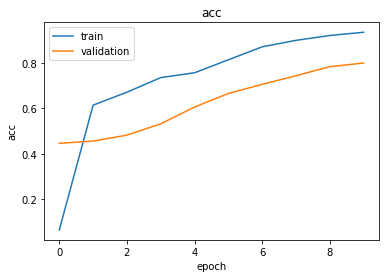

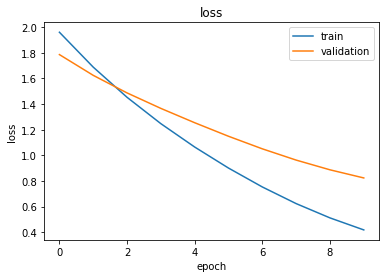

In [20]:
plot_history(history)

Evaluate the trained model on the test set

In [21]:
test_gen = generator.flow(test_data.index, test_targets)

test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.7819
	acc: 0.8109


Check serialization

In [22]:
# Save model
model_json = model.to_json()
model_weights = model.get_weights()

In [23]:
# Load model from json & set all weights
model2 = models.model_from_json(
    model_json, custom_objects={"GraphAttention": GraphAttention}
)
model2.set_weights(model_weights)
model2_weights = model2.get_weights()

In [24]:
pred2 = model2.predict_generator(test_gen)
pred1 = model.predict_generator(test_gen)
print(np.allclose(pred1, pred2))

True


# Node and link importance via saliency maps

Now we define the importances of node features, nodes, and links in the target node's neighbourhood (ego-net), and evaluate them using our library.

Node feature importance: given a target node $t$ and the model's prediction of $t$'s class, for each node $v$ in its ego-net, feature importance of feature $f$ for node $v$ is defined as the change in the target node's predicted score $s(c)$ for the winning class $c$ if feature $f$ of node $v$ is perturbed.

The overall node importance for node $v$ is defined here as the sum of all feature importances for node $v$, i.e., it is the amount by which the target node's predicted score $s(c)$ would change if we set all features of node $v$ to zeros.

Link importance for link $e=(u, v)$ is defined as the change in target node $t$'s predicted score $s(c)$ if the link $e$ is removed from the graph. Links with high importance (positive or negative) affect the target node prediction more than links with low importance.

Node and link importances can be used to assess the role of neighbour nodes and links in model's predictions for the node(s) of interest (the target nodes). For datasets like CORA-ML, the features and edges are binary, vanilla gradients may not perform well so we use integrated gradients to compute them (https://arxiv.org/pdf/1703.01365.pdf).

In [25]:
from stellargraph.utils.saliency_maps import IntegratedGradientsGAT
from stellargraph.utils.saliency_maps import GradientSaliencyGAT

Select the target node whose prediction is to be interpreted.

In [26]:
graph_nodes = list(G.nodes())
all_gen = generator.flow(graph_nodes)
target_idx = 7
target_nid = graph_nodes[target_idx]
target_gen = generator.flow([target_nid])

Node id of the target node:

In [27]:
y_true = all_targets[target_idx]  # true class of the target node

Extract adjacency matrix and feature matrix

In [28]:
y_pred = model.predict_generator(target_gen).squeeze()
class_of_interest = np.argmax(y_pred)
print(
    "target node id: {}, \ntrue label: {}, \npredicted label: {}".format(
        target_nid, y_true, y_pred.round(2)
    )
)

target node id: 1109199, 
true label: [0. 0. 1. 0. 0. 0. 0.], 
predicted label: [0.18 0.33 0.15 0.09 0.18 0.03 0.04]


Get the node feature importance by using integrated gradients

In [29]:
int_grad_saliency = IntegratedGradientsGAT(model, train_gen, generator.node_list)
saliency = GradientSaliencyGAT(model, train_gen)

Get the ego network of the target node.

In [30]:
G_ego = nx.ego_graph(Gnx, target_nid, radius=len(gat.activations))

Compute the link importance by integrated gradients.

In [31]:
integrate_link_importance = int_grad_saliency.get_link_importance(
    target_nid, class_of_interest, steps=25
)
print("integrated_link_mask.shape = {}".format(integrate_link_importance.shape))


To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

integrated_link_mask.shape = (2708, 2708)


In [32]:
integrated_node_importance = int_grad_saliency.get_node_importance(
    target_nid, class_of_interest, steps=25
)
print("\nintegrated_node_importance", integrated_node_importance.round(2))
print(
    "integrated self-importance of target node {}: {}".format(
        target_nid, integrated_node_importance[target_idx].round(2)
    )
)
print(
    "\nEgo net of target node {} has {} nodes".format(target_nid, G_ego.number_of_nodes())
)
print(
    "Number of non-zero elements in integrated_node_importance: {}".format(
        np.count_nonzero(integrated_node_importance)
    )
)


integrated_node_importance [0. 0. 0. ... 0. 0. 0.]
integrated self-importance of target node 1109199: 0.0

Ego net of target node 1109199 has 202 nodes
Number of non-zero elements in integrated_node_importance: 215


Get the ranks of the edge importance values.

In [33]:
sorted_indices = np.argsort(integrate_link_importance.flatten().reshape(-1))
sorted_indices = np.array(sorted_indices)
integrated_link_importance_rank = [(int(k / N), k % N) for k in sorted_indices[::-1]]

In [34]:
topk = 10
print(
    "Top {} most important links by integrated gradients are {}".format(
        topk, integrated_link_importance_rank[:topk]
    )
)
# print('Top {} most important links by integrated gradients (for potential edges) are {}'.format(topk, integrated_link_importance_rank_add[-topk:]))

Top 10 most important links by integrated gradients are [(1544, 163), (1206, 163), (1544, 1206), (566, 733), (566, 466), (566, 186), (566, 1816), (566, 294), (566, 483), (566, 1447)]


In the following, we plot the link and node importance (computed by integrated gradients) of the nodes within the ego graph of the target node.

For nodes, the shape of the node indicates the positive/negative importance the node has. 'round' nodes have positive importance while 'diamond' nodes have negative importance. The size of the node indicates the value of the importance, e.g., a large diamond node has higher negative importance.

For links, the color of the link indicates the positive/negative importance the link has. 'red' links have positive importance while 'blue' links have negative importance. The width of the link indicates the value of the importance, e.g., a thicker blue link has higher negative importance.

In [35]:
nx.set_node_attributes(
    G_ego, values={x[0]: {"subject": x[1]} for x in node_data["subject"].items()}
)

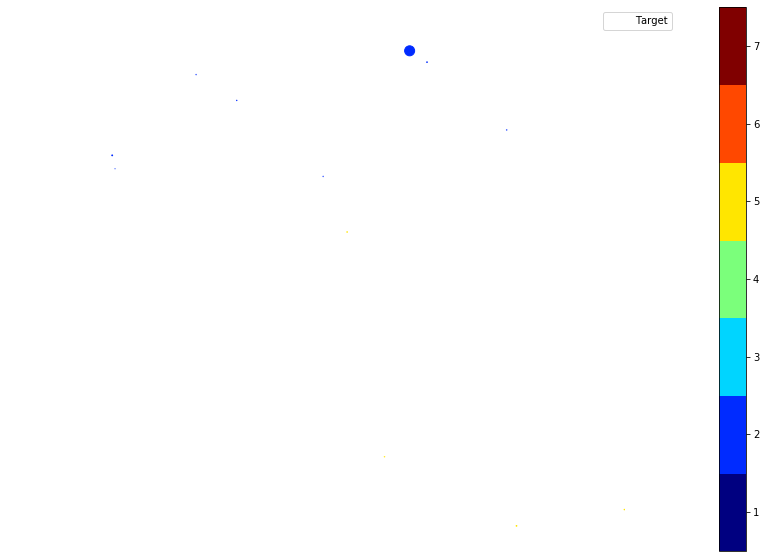

In [36]:
node_size_factor = 1e2
link_width_factor = 4

nodes = list(G_ego.nodes())
colors = pd.DataFrame(
    [v[1]["subject"] for v in G_ego.nodes(data=True)], index=nodes, columns=["subject"]
)
colors = np.argmax(target_encoding.transform(colors.to_dict("records")), axis=1) + 1

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pos = nx.spring_layout(G_ego)
# Draw ego as large and red
node_sizes = [integrated_node_importance[graph_nodes.index(k)] for k in G_ego.nodes()]
node_shapes = [
    "o" if integrated_node_importance[graph_nodes.index(k)] > 0 else "d"
    for k in G_ego.nodes()
]
positive_colors, negative_colors = [], []
positive_node_sizes, negative_node_sizes = [], []
positive_nodes, negative_nodes = [], []
# node_size_sclae is used for better visualization of nodes
node_size_scale = node_size_factor / np.max(node_sizes)
for k in range(len(node_shapes)):
    if list(nodes)[k] == target_nid:
        continue
    if node_shapes[k] == "o":
        positive_colors.append(colors[k])
        positive_nodes.append(list(nodes)[k])
        positive_node_sizes.append(node_size_scale * node_sizes[k])

    else:
        negative_colors.append(colors[k])
        negative_nodes.append(list(nodes)[k])
        negative_node_sizes.append(node_size_scale * abs(node_sizes[k]))

cmap = plt.get_cmap("jet", np.max(colors) - np.min(colors) + 1)
nc = nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=positive_nodes,
    node_color=positive_colors,
    cmap=cmap,
    node_size=positive_node_sizes,
    with_labels=False,
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    node_shape="o",
)
nc = nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=negative_nodes,
    node_color=negative_colors,
    cmap=cmap,
    node_size=negative_node_sizes,
    with_labels=False,
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    node_shape="d",
)
# Draw the target node as a large star colored by its true subject
nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=[target_nid],
    node_size=50 * abs(node_sizes[nodes.index(target_nid)]),
    node_shape="*",
    node_color=[colors[nodes.index(target_nid)]],
    cmap=cmap,
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    label="Target",
)

edges = G_ego.edges()
# link_width_scale is used for better visualization of links
weights = [
    integrate_link_importance[graph_nodes.index(u), list(Gnx.nodes()).index(v)]
    for u, v in edges
]
link_width_scale = link_width_factor / np.max(weights)
edge_colors = [
    "red"
    if integrate_link_importance[graph_nodes.index(u), list(Gnx.nodes()).index(v)] > 0
    else "blue"
    for u, v in edges
]

ec = nx.draw_networkx_edges(
    G_ego, pos, edge_color=edge_colors, width=[link_width_scale * w for w in weights]
)
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors), np.max(colors) + 1))
plt.axis("off")
plt.show()

We then remove the node or edge in the ego graph one by one and check how the prediction changes. By doing so, we can obtain the ground truth importance of the nodes and edges. Comparing the following figure and the above one can show the effectiveness of integrated gradients as the importance approximations are relatively consistent with the ground truth.

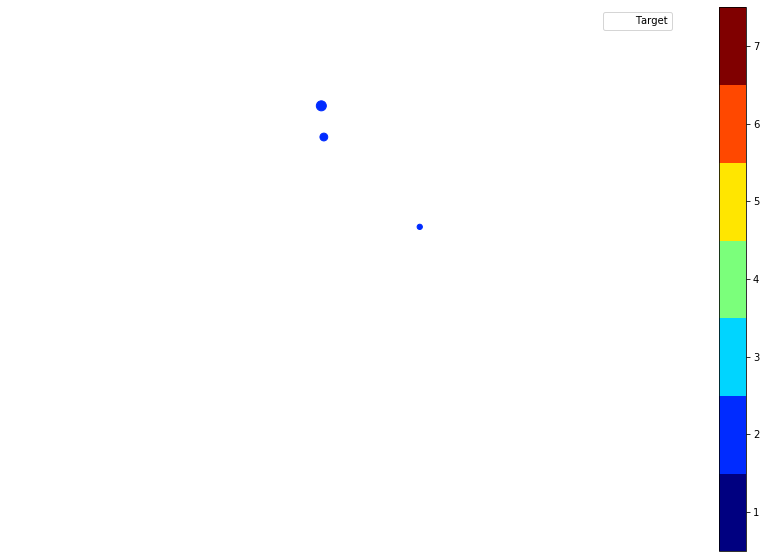

In [37]:
[X, _, A], y_true_all = all_gen[0]
N = A.shape[-1]
X_bk = deepcopy(X)
edges = [(graph_nodes.index(u), graph_nodes.index(v)) for u, v in G_ego.edges()]
nodes = [list(Gnx.nodes()).index(v) for v in G_ego.nodes()]
selected_nodes = np.array([[target_idx]], dtype="int32")
clean_prediction = model.predict([X, selected_nodes, A]).squeeze()
predict_label = np.argmax(clean_prediction)
groud_truth_edge_importance = np.zeros((N, N), dtype="float")
groud_truth_node_importance = []

for node in nodes:
    if node == target_idx:
        groud_truth_node_importance.append(0)
        continue
    X = deepcopy(X_bk)
    # we set all the features of the node to zero to check the ground truth node importance.
    X[0, node, :] = 0
    predict_after_perturb = model.predict([X, selected_nodes, A]).squeeze()
    prediction_change = (
        clean_prediction[predict_label] - predict_after_perturb[predict_label]
    )
    groud_truth_node_importance.append(prediction_change)

node_shapes = [
    "o" if groud_truth_node_importance[k] > 0 else "d" for k in range(len(nodes))
]
positive_colors, negative_colors = [], []
positive_node_sizes, negative_node_sizes = [], []
positive_nodes, negative_nodes = [], []
# node_size_scale is used for better visulization of nodes
node_size_scale = node_size_factor / max(groud_truth_node_importance)

for k in range(len(node_shapes)):
    if nodes[k] == target_idx:
        continue
    if node_shapes[k] == "o":
        positive_colors.append(colors[k])
        positive_nodes.append(graph_nodes[nodes[k]])
        positive_node_sizes.append(node_size_scale * groud_truth_node_importance[k])
    else:
        negative_colors.append(colors[k])
        negative_nodes.append(graph_nodes[nodes[k]])
        negative_node_sizes.append(node_size_scale * abs(groud_truth_node_importance[k]))

X = deepcopy(X_bk)
for edge in edges:
    original_val = A[0, edge[0], edge[1]]
    if original_val == 0:
        continue
    # we set the weight of a given edge to zero to check the ground truth link importance
    A[0, edge[0], edge[1]] = 0
    predict_after_perturb = model.predict([X, selected_nodes, A]).squeeze()
    groud_truth_edge_importance[edge[0], edge[1]] = (
        predict_after_perturb[predict_label] - clean_prediction[predict_label]
    ) / (0 - 1)
    A[0, edge[0], edge[1]] = original_val
#     print(groud_truth_edge_importance[edge[0], edge[1]])

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cmap = plt.get_cmap("jet", np.max(colors) - np.min(colors) + 1)
# Draw the target node as a large star colored by its true subject
nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=[target_nid],
    node_size=50 * abs(node_sizes[nodes.index(target_idx)]),
    node_color=[colors[nodes.index(target_idx)]],
    cmap=cmap,
    node_shape="*",
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    label="Target",
)
# Draw the ego net
nc = nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=positive_nodes,
    node_color=positive_colors,
    cmap=cmap,
    node_size=positive_node_sizes,
    with_labels=False,
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    node_shape="o",
)
nc = nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=negative_nodes,
    node_color=negative_colors,
    cmap=cmap,
    node_size=negative_node_sizes,
    with_labels=False,
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    node_shape="d",
)
edges = G_ego.edges()
# link_width_scale is used for better visulization of links
link_width_scale = link_width_factor / np.max(groud_truth_edge_importance)
weights = [
    link_width_scale
    * groud_truth_edge_importance[graph_nodes.index(u), list(Gnx.nodes()).index(v)]
    for u, v in edges
]

edge_colors = [
    "red"
    if groud_truth_edge_importance[graph_nodes.index(u), list(Gnx.nodes()).index(v)] > 0
    else "blue"
    for u, v in edges
]

ec = nx.draw_networkx_edges(G_ego, pos, edge_color=edge_colors, width=weights)
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors), np.max(colors) + 1))
plt.axis("off")
plt.show()